# <span style="color:darkgreen">DATSCIW261 ASSIGNMENT 11</span>
#### MIDS UC Berkeley, Machine Learning at Scale

<b>AUTHORS</b> : Rajesh Thallam <br>
<b>EMAIL</b>  : rajesh.thallam@ischool.berkeley.edu <br>
<b>WEEK</b>   : 12 <br>
<b>DATE</b>   : 25-Nov-15

***

<span style="color:firebrick; font-size: 120%;"><b>PySpark Configuration Test</b></span><br>

In [1]:
import os
import sys #current as of 9/26/2015
spark_home = os.environ['SPARK_HOME'] = '/usr/local/spark'

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.2
      /_/

Using Python version 2.7.6 (default, Jun 22 2015 17:58:13)
SparkContext available as sc, HiveContext available as sqlContext.


***

<h2><span style="color:dodgerblue;font:12px">HW11.0</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Broadcast versus Caching in Spark</b></span>

<span style="color:CornflowerBlue ">What is the difference between broadcasting and caching data in Spark? Give an example (in the context of machine learning) of each mechanism (at a highlevel). Feel free to cut and paste code examples from the lectures to support your answer.</span><br>

<span style="color:firebrick; font-size: 120%;"><b>Broadcasting</b></span> a variable distributes a large read-only piece of data (say a lookup table or large weight vectors in linear regression) to the workers only once instead of packaging it with every closure in the context of multiple parallel operations. When a variable is broadcasted Spark wraps the value and ensures that data is only copied to each worker once. If a variable is not broadcasted, data has to be serialized and shipped to workers every time. By broadcasting variables, we can reduce the cost of creating and executing the RDD transformations that depend on it.

In [ ]:
import numpy as np

def linearRegressionGD(data, wInitial=None, learningRate=0.05, iterations=50):
    featureLen = len(data.take(1)[0])-1
    n = data.count()
    if wInitial is None:  #start learning from a random vector
        w = np.random.normal(size=featureLen) # w should be broadcasted if it is large
    else:                 #start from provided vector
        w = wInitial
    for i in range(iterations):
        wBroadcast = sc.broadcast(w) #make available in memory as read-only to the executors (for mappers and reducers)
        gradient = data.map(lambda d: -2 * (d[0] - np.dot(wBroadcast.value, d[1:])) * np.array(d[1:])) \
                    .reduce(lambda a, b: a + b)
        w = w - learningRate * gradient/n
    return w

In the above example of linear regression (without regularization), the weight vectors are broadcasted with each iteration to all the worker nodes and the weight vectors do not change within an iteration. Weight vectors are broadcasted for every iteration. If the weight vectors are not broadcasted, then the weights are serialized and shipped to each mapper task running on the worker nodes. As mentioned in the lecture, if we are working with a 900GB file and there are 900 mappers working on each GB file then the weights are shipped to each worker node 900 times which is quite a resource intensive process. If the weight vectors are broadcasted, then weights are shipped to each worker node opposed to each task.

<span style="color:firebrick; font-size: 120%;"><b>Caching</b></span> computes and materializes an RDD in memory while keeping track of its lineage (dependencies). Since caching remembers an RDD’s lineage, Spark can recompute loss partitions in the event of node failures. RDD that is cached lives within the context of the running application, and once the application terminates, cached RDDs are deleted as well.

In [ ]:
data = sc.textFile('data.csv').map(lambda line: [float(v) for v in line.split(',')]+[1.0]).cache() #plus bias term
linearRegressionGD(data)
# added below to show usage
data_filtered = rdd1.filter(...)
data_map = rdd1.map(...)

In the above example, linear regression is applied on the data read from the file and parsed and then cached into memory. When this variable is cached, any future transformations or action will be done on the data available in the memory rather than reading from the disk. Say, for example, data_filtered variable will filter data by reading from memory instead of disk and similarly data_map variable.

<span style="color:CornflowerBlue">Review the following [Spark-notebook-based implementation](http://nbviewer.ipython.org/urls/dl.dropbox.com/s/41q9lgyqhy8ed5g/EM-Kmeans.ipynb) of KMeans and use the broadcast pattern to make this implementation more efficient. Please describe your changes in English first, implement, comment your code and highlight your changes.</span><br>

In the K-Means implementation notebook, 
- centroid is initialized as a global variable
- source data is cached and this data will be made available in the memory for future transformations or actions
- for each line in the file, nearest_centroid determines which class each point belongs to by calculating distance between the point and the current centroids. 
- the mapper emits the nearest centroid index and the point
- the reducer calculates new centroids 
- if the new centroids remains same as the previous (within threshold) then the K-means converges
- else the new centroids are fed to the next iteration

In the implementation, centroids are serialized and shipped to each mapper as part of call to the nearest_centroid function. This could be resource intensive process when the centroid vectors are large. We can reduce the cost of creating and executing the RDD transformations depending on the centroids vector by broadcasting the centroids vector to all the worker nodes before the executor tasks start using the variable. Centroid vetor does not change within an iteration and changes after each iteration. After each change this variable must be broadcasted in order to use it in the mapper tasks to calculate nearest centroid for each point.

Following are the changes to broadcast the variables and use broadcast variables in the calculations
1. Broadcast centroids for every iteration
2. In the nearest_centroid function refer broadcasted variables instead of the regular variable

In [ ]:
%matplotlib inline
import numpy as np
import pylab 

# calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    
    # ================================================
    # OPTIMIZING CODE BY USING BROADCAST VARIABLES
    # refer centroidsBroadcast instead of centroids
    # ================================================
    closest_centroid_idx = np.sum((x - centroidsBroadcast)**2, axis=1).argmin()
    # ================================================
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.csv").cache()
iter_num = 0
for i in range(10):
    
    # ================================================
    # OPTIMIZING CODE BY BROADCASTING VARIABLES
    # ================================================
    centroidsBroadcast = sc.broadcast(centroids)
    # ================================================

    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    #res [(0, (array([  2.66546663e+00,   3.94844436e+03]), 1001)  ), 
    #     (2, (array([ 6023.84995923,  5975.48511018]), 1000)), 
    #     (1, (array([ 3986.85984761,    15.93153464]), 999))]
    # res[1][1][1] returns 1000 here

    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size

    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    
    print "Iteration" + str(iter_num)
    iter_num = iter_num + 1 
    centroids = centroids_new
    
    print centroids
    plot_iteration(centroids)

print "Final Results:"
print centroids

***

<h2><span style="color:dodgerblue;font:12px">HW11.1</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Loss Functions</b></span>

<span style="color:CornflowerBlue ">In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a L2 penalized logistic regesssion learning algorithm? In your response, please discuss the loss functions, and the learnt models, and separating surfaces between the two classes.</span><br>

Both L2 logistic regression and linear SVM solve the binary classification problems. They have very similar objective functions but the approach to the results are very different. 

**L2 Logistic Regression**
\begin{equation}
\begin{split}
\sum loss(yi,xi) + \lambda.||w||^2 \\
loss(yi,xi) = −y_i⋅log(g_w(x_i)) − (1 − y_i)⋅log(1 − g_w(x_i)) \\
g_w(x_i) = \frac{1}{1−exp^{−w^Tx_i}}
\end{split}
\end{equation}

**Linear SVM**
\begin{equation}
\begin{split}
\frac{1}{2} ||w||^2 + C \sum loss(y_i, x_i) \\
loss(y_i, x_i) = max(0, 1−y_i(w^Tx_i + b))
\end{split}
\end{equation}


- Logistic regression optimizes the log likelihood by minimizing the mistakes made i.e. sum of logistic functions of the difference between the prediction $y$ and the truth $w^TX$

- Support Vector Machine finds an optimim hyperplane by maximizing the margin to classify the data. SVM places the separation so that the distance to closest misclassified entity is the widest.

If the data is linearly separable in the input space, logistic regression gives performance comparable to SVMs, but if the data is non linearly separable, then logistic regression gradually worsen depending on degree of non-linearity in the data.

<span style="color:CornflowerBlue ">In the context of binary classification problems, does the linear SVM learning algorithm yield the same result as a perceptron learning algorithm?</span><br>

Based on the async lecture, the perceptron does not try to optimize the margin between binary classification. Perceptron aims to find a hyperplane that separates the two sets and SVM tries to maximize the "support vector" i.e. the distance between two closest opposite sample points.

Perceptron might be a cheaper and faster alternative to classify the binary data but SVM might give better and accurate results as SVM tries to find an optimum plane by projecting higher dimension space.

<span style="color:CornflowerBlue">[OPTIONAL] Generate an artifical binary classification dataset with 2 input features and plot the learnt separating surface for both a linear SVM and for  logistic regression. Comment on the learnt surfaces. Please feel free to do this in Python (no need to use Spark)</span><br>

***

<h2><span style="color:dodgerblue;font:12px">HW11.2</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Gradient Descent</b></span>

<span style="color:CornflowerBlue">In the context of logistic regression describe and define three flavors of penalized loss functions.  Are these all supported in Spark MLLib (include online references to support your answers)?</span><br>

Loss functions are penalized by adding regularization term to the loss term to prevent overfitting. The benefit of adding the regularization term is that we enforce a tradeoff between matching the training data and generalizing to future data when test data is not available to assess the accuracy of the model. For logistic regression, we have following penalized loss functions

<span style="color:CornflowerBlue; font-size:120%">**1) Ridge Regression (L2 Regularization)**</span><br>

**Objective Function**

\begin{equation}
\begin{split}
arg min_w~L(w) = \underbrace{\frac{1}{n} \sum_{i = 0}^{n-1} log(1 + e^{-y.w^T.x_i})}_\text{Loss} + \underbrace{\lambda . w^T . w}_\text{Penalty} \\
y \in \{-1, 1\}
\end{split}
\end{equation}

${\lambda . w^T . w}$ is the ridge regularization parameter.

**Gradient Descent**

\begin{equation}
\frac{\partial L}{\partial w} = \frac{1}{n} \sum_{i = 0}^{n-1} (\frac{1}{1+e^{-y.w^T.x_i}} -1 ).y_i.x_i + \lambda w
\end{equation}

Ridge regression shrinks the estimated coefficients towards zero. The tuning parameter $\lambda$ controls strength of the penalty term.
- The bias increases as $\lambda$ increases (penalty)
- The variance decreases as $\lambda$ increases (penalty)

<span style="color:CornflowerBlue; font-size:120%">**2) Lasso Regression (L1 Regularization)**</span><br>

**Objective Function**

\begin{equation}
\begin{split}
arg min_w~L(w) = \underbrace{\frac{1}{n} \sum_{i = 0}^{n-1} log(1 + e^{-y.w^T.x_i})}_\text{Loss} + \underbrace{\lambda . |w|}_\text{Penalty} \\
y \in \{-1, 1\}
\end{split}
\end{equation}

${\lambda . w^T . w}$ is the ridge regularization parameter.

**Gradient Descent**

\begin{equation}
\frac{\partial L}{\partial w} = \frac{1}{n} \sum_{i = 0}^{n-1} (\frac{1}{1+e^{-y.w^T.x_i}} -1 ).y_i.x_i + \lambda .  sgn(w)
\end{equation}

The only difference between the lasso problem and ridge regression is that the latter uses a (squared) L2 penalty $w^T.w$, while the former uses an L1 penalty $|w|$. The tuning parameter $\lambda$ controls strength of the penalty term. For $\lambda$ in between these two extremes, the nature of the L1 penalty causes some coefficients to be shrunken to zero exactly.

<span style="color:CornflowerBlue; font-size:120%">**3) Huber Loss**</span><br>

Huber loss is one of the robust loss function that provides strong resistance to the outliers while being efficent at same time.

**Loss function**

\begin{equation}
    L(y,f(x)) = \left\{
                \begin{array}{ll}
                  [y - f(x)]^2, \text{for |y − f(x)| ≤ δ } \\
                  2\delta |y - f(x)| - \delta ^2, \text{otherwise}
                \end{array}
              \right.
\end{equation} 

This function is quadratic for small values of errors $ |y - f(x)| $, and linear for large values, with equal values and slopes of the different sections at the two points where $ |y − f(x)| ≤ δ $. 

<span style="color:CornflowerBlue; font-size:120%">**Spark MLlib Support**</span><br>

Currently, Spark MLlib supports only L1 (Lasso) and L2 (Ridge) penalties. Huber loss is not available in Spark MLlib. Here is the [reference](http://spark.apache.org/docs/latest/mllib-linear-methods.html#regularizers) to Apache Spark MLlib documentation on the regularization functions supported 

<span style="color:CornflowerBlue">Descibe probabilitic interpretations of the L1 and L2 priors for penalized logistic regression (HINT: see synchronous slides for week 11 for details)</span><br>

Let us imagine that to infer some parameter $\beta$ from some observed input-output pairs $(x_1, y_1), ... ,(x_N,y_N)$. Assume that the outputs are linearly related to the inputs via $\beta$ and is augmented with some noise $\epsilon$: $$y_n = \beta x_n + \epsilon $$

where $\epsilon$ is Gaussian noise with mean $\theta$ and variance $\sigma ^2$. This gives raise to a Gaussian likelihood:

$$ \prod_{n=1}^{N} N(y_n|\beta x_n, \sigma ^2) $$

Let us regularise parameter $\beta$ by imposing the Gaussian prior $ N(\beta|0, \lambda ^{−1}) $

where $\lambda$ is a strictly positive scalar. Hence, combining the likelihood and the prior we simply have:

$$ \prod_{n=1}^{N} N(y_n|\beta x_n, \sigma ^2) . N(\beta|0, \lambda ^{−1}) $$

Taking the logarithm of the above expression and dropping constants,

$$ \sum_{n=1}^{N} \frac{1}{n^2} (y_n - \beta x_n)^2 - \lambda \beta + constant $$

If we maximise the above expression with respect to $\beta$ we get the so called maximum a-posteriori estimate for $\beta$. In this expression it becomes apparent why the Gaussian prior can be interpreted as a L2 regularisation term.

![L1 vs L2](L1_vs_L2.png)

L1/Laplace tends to tolerate both large values as well as very small values of coefficients more than L2/Gaussian (tails) i.e. L1 drives $w$ to zero more efficiently than L2.

***

<h2><span style="color:dodgerblue;font:12px">HW11.3</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>Logistic Regression</b></span>

<span style="color:CornflowerBlue ">Generate 2 sets of linearly separable data with 100 data points each using the data generation code provided below and plot each in separate plots. Call one the training set and the other the testing set.</span><br>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from numpy.random import rand

In [3]:
def generateData(n):
    """ 
    generates a 2D linearly separable dataset with n samples. 
    The third element of the sample is the label
    """
    xb = ((rand(n)*2-1)/2-0.5)
    yb = ((rand(n)*2-1)/2+0.5)
    xr = ((rand(n)*2-1)/2+0.5)
    yr = ((rand(n)*2-1)/2-0.5)
    
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i], 1])
        inputs.append([xr[i],yr[i], 0])
    
    return inputs

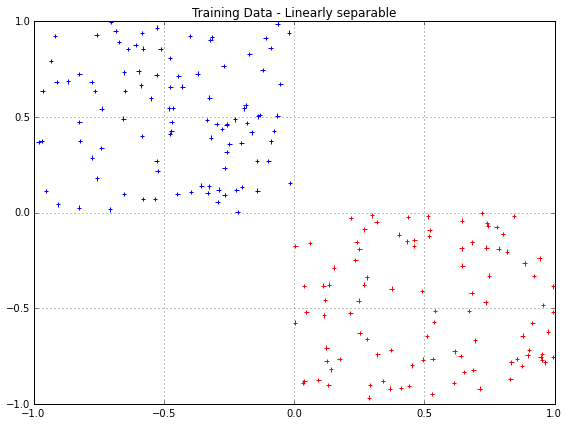

In [4]:
l_sep = np.array(generateData(100))
colors = list(np.select([l_sep[:,2] == 0, l_sep[:,2] == 1 ], ['r', 'b']))

plt.figure(figsize=(8, 6))
plt.title('Training Data - Linearly separable')
plt.scatter(l_sep[:, 0], l_sep[:, 1], marker='+', c=colors)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid()
plt.tight_layout()
plt.show()

<span style="color:cornflowerblue">Modify this data generation code to generate non-linearly separable training and testing datasets (with approximately 10% of the data falling on the wrong side of the separating hyperplane. Plot the resulting datasets. <br>
NOTE: For the remainder of this problem please use the non-linearly separable training and testing datasets</span><br>

In [6]:
def generateInseparableData(n, skew = 0.9):
    """ 
    generates a 2D linearly inseparable dataset with n samples. 
    The third element of the sample is the label
    """
    
    n1 = int(round(skew * n, 0))
    n2 = int(round((1-skew) * n, 0))
    
    print n1, n2
    
    xb = np.concatenate([((rand(n1)*2-1)/2-0.5), ((rand(n2)*2-1)/2+0.5)], axis=0)
    yb = np.concatenate([((rand(n1)*2-1)/2+0.5), ((rand(n2)*2-1)/2-0.5)], axis=0 )
    xr = np.concatenate([((rand(n1)*2-1)/2+0.5), ((rand(n2)*2-1)/2-0.5)], axis=0 )
    yr = np.concatenate([((rand(n1)*2-1)/2-0.5), ((rand(n2)*2-1)/2+0.5)], axis=0 )
        
    inputs = []
    for i in range(len(xb)):
        inputs.append([xb[i],yb[i], 1])
        inputs.append([xr[i],yr[i], 0])
    
    return inputs

90 10


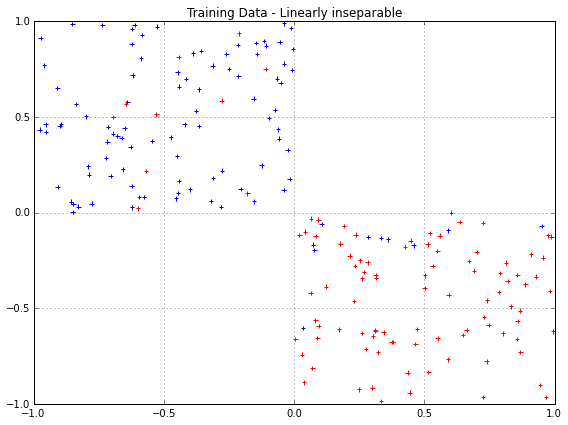

In [7]:
l_insep = np.array(generateInseparableData(100))
colors = list(np.select([l_insep[:,2] == 0, l_insep[:,2] == 1 ], ['r', 'b']))

plt.figure(figsize=(8, 6))
plt.title('Training Data - Linearly inseparable')
plt.scatter(l_insep[:, 0], l_insep[:, 1], marker='+', c=colors)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid()
plt.tight_layout()
plt.show()

<span style="color:cornflowerblue">Using MLLib  train up a LASSO logistic regression model with the training dataset and evaluate with the testing set. What a good number of iterations for training the logistic regression model? Justify with plots and words.</span><br>

<span style="color:cornflowerblue; font-size:120%"><b>Lasso Logistic Regression using MLLib</b></span>

Total data set count: 200
Training data set count: 100
Test data set count: 100


Iteration  | Weights                             | Intercept  | Test Error (1-Accuracy)
1          | [-0.186144160714,0.203199080068]    | 0.0        | 0.1
2          | [-0.300977792253,0.329399392171]    | 0.0        | 0.1
3          | [-0.386433952156,0.423785876327]    | 0.0        | 0.1
5          | [-0.513040262815,0.564462992978]    | 0.0        | 0.1
10         | [-0.715342681837,0.791758387237]    | 0.0        | 0.1
20         | [-0.944778142063,1.0544822788]      | 0.0        | 0.1
50         | [-1.26844441216,1.43889954573]      | 0.0        | 0.1
100        | [-1.50943017134,1.74298347146]      | 0.0        | 0.1
200        | [-1.72468213334,2.03938676768]      | 0.0        | 0.1
250        | [-1.72468213334,2.03938676768]      | 0.0        | 0.1
300        | [-1.72468213334,2.03938676768]      | 0.0        | 0.1
400        | [-1.72468213334,2.03938676768]      | 0.0        | 0.1
500        | [

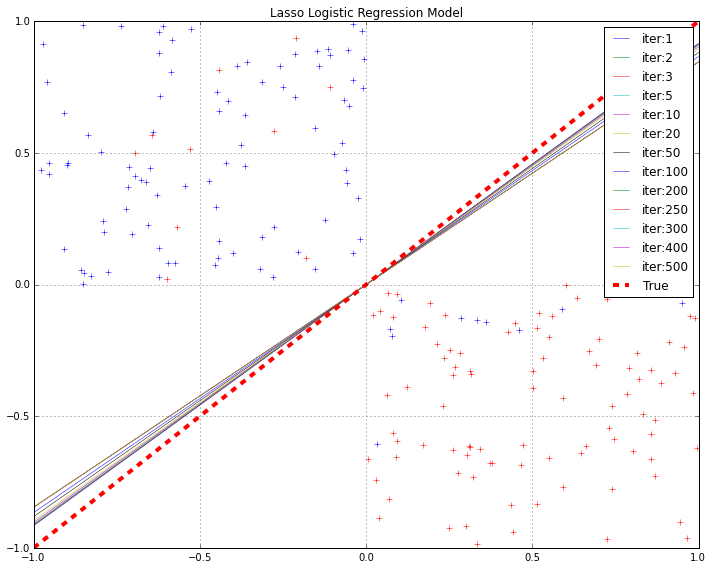

In [15]:
import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import LogisticRegressionWithSGD, LogisticRegressionModel

iterations = [1, 2, 3, 5, 10, 20, 50, 100, 200, 250, 300, 400, 500]

# mllib local vector associated with a label
def labeled_point(value):
    return LabeledPoint(value[2], value[0:2])

# load linearlt inseparable data
data = np.array(l_insep)

# split data into training and test, onvert into RDD of LabeledPoint for MLlib
training_set = sc.parallelize(data[data[:, 2] == 1]).map(labeled_point).cache()
test_set = sc.parallelize(data[data[:, 2] == 0]).map(labeled_point).cache()

print "="*80
print "Total data set count: {}".format(len(data))
print "Training data set count: {}".format(training_set.count())
print "Test data set count: {}".format(test_set.count())
print "="*80

x1 = [-1.0, 1.0]

# plot data points
plt.figure(figsize=(10, 8))

for x, y, label in data:
    if label == 1:
        plt.plot(x, y, 'b+')
    else:
        plt.plot(x, y, 'r+')

print "\n"
print "="*80
print "{0: <10} | {1: <35} | {2: <10} | {3}".format("Iteration", "Weights", "Intercept", "Test Error (1-Accuracy)")
print "="*80

for iteration in iterations:
    # build the model
    model = LogisticRegressionWithSGD.train(training_set, iterations=iteration, regType='l1', initialWeights=[0,0], regParam=0.01)

    # plot decision boundary    
    x2 = [- i * model.weights[0] / model.weights[1] for i in x1]
    plt.plot(x1, x2, label='iter:' + str(iteration), linewidth=0.5)
    
    # evaluating the model on training data
    #training_labels_and_preds = training_set.map(lambda p: (p.label, model.predict(p.features)))
    #training_accuracy = training_labels_and_preds.filter(lambda (v, p): v == p).count() / float(training_set.count())
    #training_accuracy = 0.0
    
    # Evaluating the model on test data
    test_labels_and_preds = test_set.map(lambda p: (p.label, model.predict(p.features)))
    test_accuracy = test_labels_and_preds.filter(lambda (v, p): v == p).count() / float(test_set.count())
    
    print "{0: <10} | {1: <35} | {2: <10} | {3}".format(iteration, model.weights, model.intercept, 1-test_accuracy)
    
print "="*80

plt.plot([-1, 1], [-1, 1], 'r--', label='True', linewidth=4.0)
plt.legend()
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid()
plt.title('Lasso Logistic Regression Model')
plt.tight_layout()
plt.show()

<span style="color:cornflowerblue; font-size:120%"><b>Results</b></span>

**As evident from the plot and the results, model converged between 100 and 200 iterations as the weights remain constant after 200 iterations. Model accuracy on the test set has been 90% from the inception. The true boundary  and decision boundary have same intercept but the slope varies and remains constant after 200 iterations. Even though slope varies, decision boundary classifies the data with 90% accuracy.**

<span style="color:cornflowerblue">Derive and implement in Spark a weighted  LASSO logistic regression. Implement a convergence test of your choice to check for termination within your training algorithm. Weight the above training dataset as follows:  Weight each example using the inverse vector length (Euclidean norm): <br><br>
weight(X)= 1/||X||, <br>
where ||X|| = SQRT(X.X)= SQRT(X1^2 + X2^2) <br>
Here X is vector made up of X1 and X2. <br><br>
Evaluate your homegrown weighted  LASSO logistic regression on the test dataset. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge.
</span><br>

<span style="color:cornflowerblue; font-size:120%"><b>Weighted Lasso Logistic Regression in Spark</b></span>

In [44]:
# gradient descent with regularization using Spark
# Objective Function
#     minw   λ/2   w’w   +   1/m Σi log(1+exp(yi(w’xi – b)))   
# gradient 
#    -y*(1-1/(1+exp(yi(w’xi – b))))*(x/||x||)

def logisticRegressionGDReg_Spark(data, test=None, initialWeights=None, learningRate=0.05, iterations=50, regParam=0.01, regType=None, tolerance=0.0001):

    delta = 0.0
    report_iterations = [1, 2, 3, 4, 5, 10, 15, 20, 25, 50, 75, 100, 200, 300, 400, 500, 1000, 1500]
    
    featureSize = len(data.take(1)[0].features)
    n = data.count()
    converged = False

    if initialWeights is None:
        w = np.random.normal(size=featureSize) # w should be broadcasted if it is large
    else:
        w = initialWeights
        
    if test!= None:
        predicted_total = test.count()

    print "="*80
    print "Weighted Lasso Logistic Regression in Spark"
    print "="*80
    print "Regularization Type = {}".format(regType)
    print "Initial weights = {}".format(initialWeights)
    print "Iterations = {}".format(iterations)
    print "Regularization Parameter = {}".format(regParam)
    print "Learning Rate = {}".format(learningRate)
    print "Tolerance/Stop Criteria = {}".format(tolerance)
    print "="*80
    print "{0: <10} | {1: <25} | {2: <20} | {3}".format("Iteration", "Weights", "Delta", "Test Error (1-Accuracy)")
    print "="*80
    
    x1 = [-1.0, 1.0]

    # plot data points
    plt.figure(figsize=(10, 8))

    for x, y, label in l_insep:
        if label == 1:
            plt.plot(x, y, 'b+')
        else:
            plt.plot(x, y, 'r+')
    
    for i in range(iterations):
        wBroadcast = sc.broadcast(w)

        # gradient log loss
        # weight each example using the inverse vector length (Euclidean norm)
        gradient = data.map(lambda p: \
                            (1 / (1 + np.exp(-p.label*np.dot(wBroadcast.value, p.features)))-1) \
                            * p.label \
                            * p.features \
                            * np.reciprocal(np.sqrt(np.sum(np.square(p.features))))) \
                       .reduce(lambda x, y: x + y)/n

        if regType == "Ridge":
            wreg = wBroadcast.value * 1
            wreg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
        elif regType == "Lasso":
            wreg = wBroadcast.value * 1
            wreg[-1] = 0 #last value of weight vector is bias term, ignored in regularization
            wreg = (wreg>0).astype(int) * 2-1
        else:
            wreg = np.zeros(wBroadcast.value.shape[0])

        wdelta = learningRate * (gradient + regParam * wreg)  #gradient: hinge loss + regularized term 
        gradient = gradient + regParam * wreg  #gradient:  GD of Sqaured Error+ GD of regularized term 
        
        if np.sum(np.abs(wdelta)) <= tolerance*np.sum(np.abs(wBroadcast.value)): # converged as updates to weight vector are small
            converged = True
            break
        else:
            delta = np.sum(np.abs(wdelta)) - tolerance*np.sum(np.abs(wBroadcast.value))
        
        w = wBroadcast.value - wdelta
        
        if test != None:
            predicted_correct = test.map(lambda p: np.dot(w, p.features) - p.label).filter(lambda x: x < 0).count()
            accuracy = predicted_correct / float(predicted_total)
            errors = 1 - accuracy
        
        if (i in report_iterations) or (converged) or (i%100 == 0):
            print "{0: <10} | {1: <25} | {2: <20} | {3}".format(i, w, delta, errors)
            
            # plot decision boundary    
            x2 = [- j * w[0] / w[1] for j in x1]
            plt.plot(x1, x2, label='iter:' + str(i), linewidth=0.5)
        
    print "="*80
    print "Final weights = {}".format(w)
    print "Total iterations for convergence = {}".format(i)
    
    plt.plot([-1, 1], [-1, 1], 'r--', label='True', linewidth=4.0)
    plt.legend()
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid()
    plt.title('Lasso Logistic Regression Model with Spark')
    plt.tight_layout()
    plt.show()
    
    return [w, i]

Weighted Lasso Logistic Regression in Spark
Regularization Type = Lasso
Initial weights = None
Iterations = 1500
Regularization Parameter = 0.01
Learning Rate = 0.05
Tolerance/Stop Criteria = 0.001
Iteration  | Weights                   | Delta                | Test Error (1-Accuracy)
0          | [-1.13571478  0.70392289] | 0.0110401547061      | 0.1
1          | [-1.14082492  0.71160652] | 0.0109541290478      | 0.1
2          | [-1.14590124  0.71925146] | 0.0108688283135      | 0.1
3          | [-1.15094406  0.72685804] | 0.0107842444838      | 0.1
4          | [-1.15595368  0.73442659] | 0.0107003696312      | 0.1
5          | [-1.1609304   0.74195744] | 0.0106171959191      | 0.1
10         | [-1.18533083  0.77905751] | 0.0102115764851      | 0.1
15         | [-1.20895204  0.81526241] | 0.00982236138944     | 0.1
20         | [-1.23182794  0.85060935] | 0.00944866975329     | 0.1
25         | [-1.25399055  0.88513353] | 0.00908967255793     | 0.1
50         | [-1.35510548  1.04652

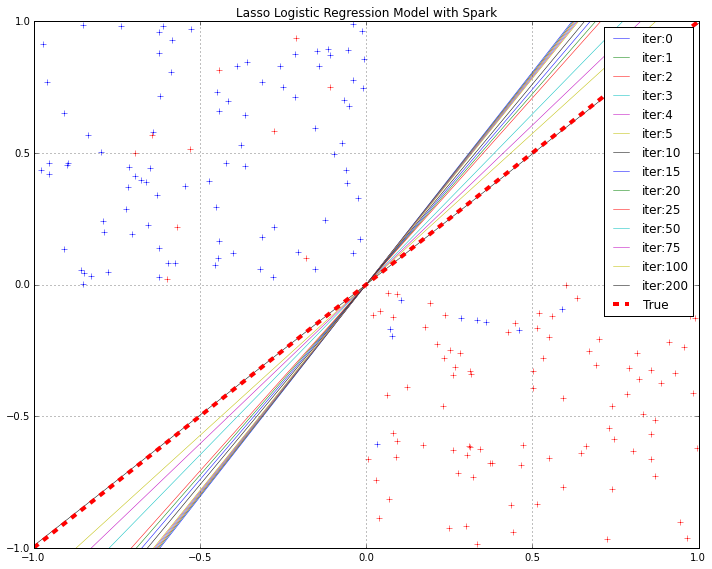

In [45]:
# data is previously generated in HW 11.3 and cached as training and test data set
np.random.seed(400)

w, i = logisticRegressionGDReg_Spark(training_set, test_set, regType="Lasso", iterations=1500, tolerance=0.001)

<span style="color:cornflowerblue">Does Spark MLLib have a weighted LASSO logistic regression implementation. If so use it and report your findings on the weighted training set and test set.</span>

**I could not find weighted Lasso logistic regression implementation in Spark MLlib library.**

***

<h2><span style="color:dodgerblue;font:12px">HW11.4</span></h2>

<span style="color:firebrick; font-size: 120%;"><b>Support Vector Machine (SVM)</b></span>

<span style="color:CornflowerBlue">Use the non-linearly separable training and testing datasets from HW11.3 in this problem. Using MLLib  train up a soft SVM model with the training dataset and evaluate with the testing set. What is a good number of iterations for training the SVM model? Justify with plots and words. </span><br>

<span style="color:cornflowerblue; font-size:120%"><b>SVM in MLLib</b></span>

Total data set count: 200
Training data set count: 100
Test data set count: 100


Iteration  | Weights                             | Intercept  | Test Prec
1          | [-0.392288321429,0.426398160137]    | 0.0        | 0.1
2          | [-0.666904156369,0.72489210035]     | 0.0        | 0.1
5          | [-1.00956160483,1.09110026072]      | 0.0        | 0.1
10         | [-1.15895137936,1.22462467663]      | 0.0        | 0.1
20         | [-1.24135748637,1.33370718509]      | 0.0        | 0.1
50         | [-1.32207443873,1.40789819566]      | 0.0        | 0.1
75         | [-1.32207443873,1.40789819566]      | 0.0        | 0.1
100        | [-1.32207443873,1.40789819566]      | 0.0        | 0.1
200        | [-1.32207443873,1.40789819566]      | 0.0        | 0.1
300        | [-1.32207443873,1.40789819566]      | 0.0        | 0.1
400        | [-1.32207443873,1.40789819566]      | 0.0        | 0.1
500        | [-1.32207443873,1.40789819566]      | 0.0        | 0.1
1000       | [-1.32207443873

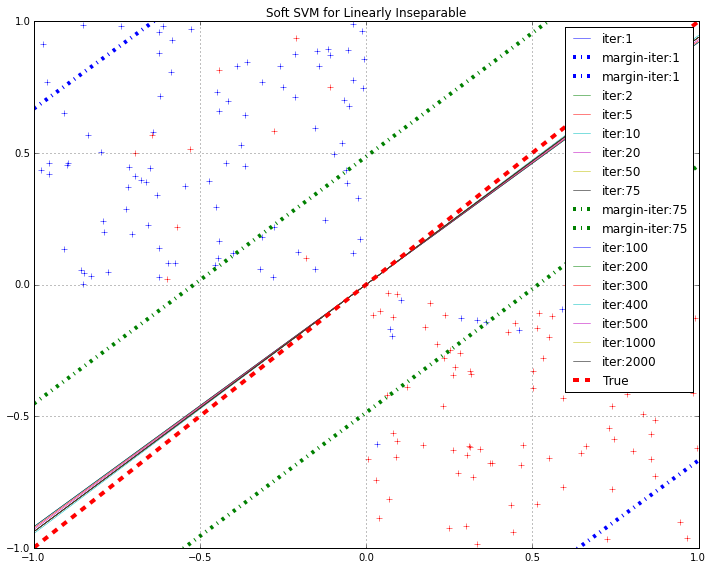

In [28]:
import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.classification import SVMWithSGD

iterations = [1, 2, 5, 10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]

# mllib local vector associated with a label
def labeled_point(value):
    return LabeledPoint(value[2], value[0:2])

# load linearlt inseparable data
data = np.array(l_insep)

# split data into training and test, onvert into RDD of LabeledPoint for MLlib
training_set = sc.parallelize(data[data[:, 2] == 1]).map(labeled_point).cache()
test_set = sc.parallelize(data[data[:, 2] == 0]).map(labeled_point).cache()

print "="*80
print "Total data set count: {}".format(len(data))
print "Training data set count: {}".format(training_set.count())
print "Test data set count: {}".format(test_set.count())
print "="*80

x1 = [-1.0, 1.0]

# plot data points
plt.figure(figsize=(10, 8))

for x, y, label in data:
    if label == 1:
        plt.plot(x, y, 'b+')
    else:
        plt.plot(x, y, 'r+')

print "\n"
print "="*80
print "{0: <10} | {1: <35} | {2: <10} | {3}".format("Iteration", "Weights", "Intercept", "Test Prec")
print "="*80

for iteration in iterations:
    # build the model
    model = SVMWithSGD.train(training_set, iterations=iteration, initialWeights=[0,0], regParam=0.01)

    # plot decision boundary    
    x2 = [- i * model.weights[0] / model.weights[1] for i in x1]
    plt.plot(x1, x2, label='iter:' + str(iteration), linewidth=0.5)
    
    # get the separating hyperplane
    w = model.weights
    a = -w[0] / w[1]

    # plot the parallels to the separating hyperplane that pass through the
    # support vectors
    margin = 1 / np.sqrt(np.sum(np.square(model.weights)))
    x2_down = x2 + a * margin
    x2_up = x2 - a * margin

    # plot the line, the points, and the nearest vectors to the plane
    color = {1:'b', 75:'g'}
    if iteration in color:
        plt.plot(x1, x2_down, '-.', linewidth=4.0, color=color[iteration], label='margin-iter:' + str(iteration))
        plt.plot(x1, x2_up, '-.', linewidth=4.0, color=color[iteration], label='margin-iter:' + str(iteration))
    
    # evaluating the model on training data
    #training_labels_and_preds = training_set.map(lambda p: (p.label, model.predict(p.features)))
    #training_accuracy = training_labels_and_preds.filter(lambda (v, p): v == p).count() / float(training_set.count())
    #training_accuracy = 0.0
    
    # Evaluating the model on test data
    test_labels_and_preds = test_set.map(lambda p: (p.label, model.predict(p.features)))
    test_errors = test_labels_and_preds.filter(lambda (v, p): v != p).count() / float(test_set.count())
    
    print "{0: <10} | {1: <35} | {2: <10} | {3}".format(iteration, model.weights, model.intercept, test_errors)
    
print "="*80

plt.plot([-1, 1], [-1, 1], 'r--', label='True', linewidth=4.0)
plt.legend()
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.grid()
plt.title('Soft SVM for Linearly Inseparable')
plt.tight_layout()
plt.show()

<span style="color:cornflowerblue; font-size:120%"><b>Results</b></span>

**Soft SVM took about 75 iterations before converging using linear inseparable data. With test data set, soft SVM predicted classes with 90% accuracy. As evident when SVM started iteration it had a huge margin and then converged to an optimum plane after 75 iterations. This margin does not classify all the examples correctly which is expected from soft SVM.**

<span style="color:CornflowerBlue">Derive and Implement in Spark a weighted soft linear svm classification learning algorithm. Evaluate your homegrown weighted soft linear svm classification learning algorithm on the weighted training dataset and test dataset from HW11.3. Report misclassification error (1 - Accuracy) and how many iterations does it took to converge?  How many support vectors do you end up? </span><br>

<span style="color:cornflowerblue; font-size:120%"><b>Soft SVM using Spark</b></span>

In [41]:
#gradient descent (and with NO stochasticity!)
# Objective Function
# minw   λ/2   w’w   +   1/m Σi(1   –    yi(w’xi – b))+
# gradient 
#   λw               if      yi(w’xi – b))  > 1    #correctly classified
#   λw  + yi xi      Otherwise                    #incorrectly classified
#--------------------------------
#Wt+1  = wt + average(gradient)
#Wt+1  = wt + average(regularization + hinge loss)

def WeightedSVMGD_Spark(data, test=None, initialWeights=None, learningRate=0.05, iterations=50, regParam=0.01, tolerance=0.0001):

    delta = 0.0
    report_iterations = [1, 2, 5, 10, 20, 50, 75, 100, 200, 300]
    converged = False
    
    featureSize = len(data.take(1)[0].features)
    n = data.count()

    if initialWeights is None:
        w = np.random.normal(size=featureSize) # w should be broadcasted if it is large
    else:
        w = initialWeights

    print "="*80
    print "Weighted SVM Logistic Regression in Spark"
    print "="*80
    print "Initial weights = {}".format(initialWeights)
    print "Iterations = {}".format(iterations)
    print "Regularization Parameter = {}".format(regParam)
    print "Learning Rate = {}".format(learningRate)
    print "Tolerance/Stop Criteria = {}".format(tolerance)
    print "="*80
    print "{0: <10} | {1: <25} | {2: <18} | {3: <10} | {4}".format("Iteration", "Weights", "Delta", "Errors", "SV Count")
    print "="*80

    x1 = [-1.0, 1.0]

    # plot data points
    plt.figure(figsize=(10, 8))

    for x, y, label in l_insep:
        if label == 1:
            plt.plot(x, y, 'b+')
        else:
            plt.plot(x, y, 'r+')
    
    for i in range(iterations):       #label * margin
        wBroadcast = sc.broadcast(w)

        #Support vector? with label*margin<1
        sv = data.filter(lambda p: p.label * np.dot(wBroadcast.value, p.features)<1)

        if sv.isEmpty(): # converged as no more updates possible
            break       
            
        # hinge loss component of gradient y*x and sum up 
        # weight each example using the inverse vector length (Euclidean norm)
        # gradient: avg hinge loss
        gradient = -1 * sv.map(lambda p: \
                               p.label * 
                               p.features * \
                               np.reciprocal(np.sqrt(np.sum(np.square(p.features))))) \
                          .reduce(lambda x,y: x+y)/n
                
        wreg = wBroadcast.value*1   #temp copy of weight vector
        wreg[-1] = 0 #last value of weight vector is bias term; ignore in regularization
        wdelta = learningRate * (gradient + regParam * wreg)   #gradient: hinge loss + regularized term 

        if np.sum(np.abs(wdelta)) <= tolerance*np.sum(np.abs(wBroadcast.value)): # converged as updates to weight vector are small
            converged = True
        else:
            delta = np.sum(np.abs(wdelta)) - tolerance*np.sum(np.abs(wBroadcast.value))

        w = w - wdelta
        
        if test != None:
            predicted_total = test.count()
            predicted_correct = test.map(lambda p: np.dot(w, p.features) - p.label).filter(lambda x: x < 0).count()
            accuracy = predicted_correct / float(predicted_total)
            errors = 1 - accuracy
        
        if (i in report_iterations) or (converged) or (i%100 == 0):
            print "{0: <10} | {1: <25} | {2: <18} | {3: <10} | {4}".format(i, w, delta, errors, sv.count())
        
        # plot decision boundary    
        x2 = [- j * w[0] / w[1] for j in x1]

        # get the separating hyperplane
        a = -w[0] / w[1]

        # plot the parallels to the separating hyperplane that pass through the
        # support vectors
        margin = 1 / np.sqrt(np.sum(np.square(w)))
        x2_down = x2 + a * margin
        x2_up = x2 - a * margin

        # plot the line, the points, and the nearest vectors to the plane
        if converged:
            final_iter = i
        else:
            final_iter = 0

        color = {1:'b', final_iter:'g'}
        if i in color:
            plt.plot(x1, x2, '--', color=color[i], label='iter:' + str(i), linewidth=0.5)
            plt.plot(x1, x2_down, '-.', linewidth=4.0, color=color[i], label='margin-iter:' + str(i))
            plt.plot(x1, x2_up, '-.', linewidth=4.0, color=color[i], label='margin-iter:' + str(i))
    
        if converged:
            break
    
    print "="*80
    print "Final weights = {}".format(w)
    print "Total iterations for convergence = {}".format(i)
    print "Total support vector count = {}".format(sv.count())
    
    plt.plot([-1, 1], [-1, 1], 'r--', label='True', linewidth=4.0)
    plt.legend()
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    plt.grid()
    plt.title('Soft SVM for Linearly Inseparable with Spark')
    plt.tight_layout()
    plt.show()
        
    return [w, i]

Weighted SVM Logistic Regression in Spark
Initial weights = None
Iterations = 10000
Regularization Parameter = 0.01
Learning Rate = 0.05
Tolerance/Stop Criteria = 0.001
Iteration  | Weights                   | Delta              | Errors     | SV Count
0          | [-1.14158912  0.71270592] | 0.0256975200156    | 0.1        | 67
1          | [-1.15240753  0.72875106] | 0.0250092582944    | 0.1        | 66
2          | [-1.16272119  0.74477057] | 0.0244520128788    | 0.1        | 65
5          | [-1.19059056  0.79003499] | 0.0212835194413    | 0.1        | 60
10         | [-1.22972394  0.86139149] | 0.0186538204504    | 0.1        | 56
20         | [-1.286458    0.97986522] | 0.0136167866683    | 0.1        | 48
50         | [-1.39913612  1.19020588] | 0.00652479636653   | 0.1        | 37
75         | [-1.4693554   1.31794979] | 0.00391806417466   | 0.1        | 33
100        | [-1.52368416  1.40308191] | 0.00214327625262   | 0.1        | 30
200        | [-1.62446943  1.69518245] | 4.80

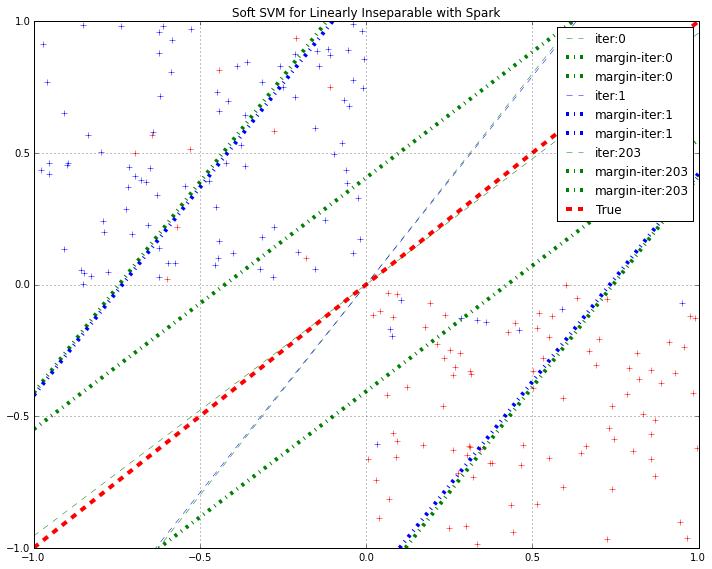

Final weights = [-1.62655209  1.7025461 ]
Total iterations for convergence = 203


In [42]:
# data is previously generated in HW 11.3 and cached as training and test data set
np.random.seed(400)

w, i = WeightedSVMGD_Spark(training_set, test=test_set, iterations=10000, tolerance=0.001)
print "Final weights = {}".format(w)
print "Total iterations for convergence = {}".format(i)

<span style="color:cornflowerblue; font-size:120%"><b>Results</b></span>

Homegrown spark implementation of SVM converged after 203 iterations with 26 support vectors in the plane. As can be seen, true decision boundary is very close to the final decision boundary. With soft SVM model error rate or misclassification rate is consisently 10%.

<span style="color:CornflowerBlue">Does Spark MLLib have a weighted soft SVM learner. If so use it and report your findings on the weighted training set and test set.</span><br>

**I could not find soft SVM implementation in Spark MLlib module. I could find an equivalent in scikit learn.**

***

<h2><span style="color:dodgerblue;font:12px">HW11.5</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>[OPTIONAL] Distributed Perceptron Algorithm</b></span>

<span style="color:CornflowerBlue ">Using the following papers as background: [link1](http://static.googleusercontent.com/external_content/untrusted_dlcp/research.google.com/en//pubs/archive/36266.pdf) [link2](https://www.dropbox.com/s/a5pdcp0r8ptudgj/gesmundo-tomeh-eacl-2012.pdf?dl=0) [link3](http://www.slideshare.net/matsubaray/distributed-perceptron ) <br>
Implement each of the following flavors of perceptron learning algorithm:
</span><br>

<span style="color:CornflowerBlue">11.5.1 Serial (All Data): This is the classifier returned if trained serially on all the available data.  On a single computer for example (Mistake driven)<br></span>

<span style="color:CornflowerBlue ">11.5.2 Serial (Sub Sampling): Shard the data, select one shard randomly and train serially.</span><br>

<span style="color:CornflowerBlue ">11.5.3 Parallel (Parameter Mix): Learn a perceptron locally on each shard. Once learning is complete combine each learnt percepton using a uniform weighting</span><br>

<span style="color:CornflowerBlue ">11.5.4 Parallel (Iterative Parameter Mix) as described in the above papers.</span>

***

<h2><span style="color:dodgerblue;font:12px">HW11.6</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>[OPTIONAL] Evaluation of perceptron algorihtms on PennTreeBank POS corpus</b></span>

<span style="color:CornflowerBlue ">Reproduce the experiments reported in the following paper: [HadoopPerceptron: a Toolkit for Distributed Perceptron Training and Prediction with MapReduce, Andrea Gesmundo and  Nadi Tomeh](http://www.aclweb.org/anthology/E12-2020). These experiments focus on the prediction accuracy on a part-of-speech
(POS) task using the PennTreeBank corpus. They use sections 0-18 of the Wall Street Journal for training, and sections 22-24 for testing.</span><br>

***

<h2><span style="color:dodgerblue;font:12px">HW11.7</span></h2> 

<span style="color:firebrick; font-size: 120%;"><b>[OPTIONAL] Kernal Adatron</b></span>

<span style="color:CornflowerBlue">Implement the Kernal Adatron in Spark</span>

***

<span style="color:firebrick">** -- END OF ASSIGNMENT 11 -- **</span>